# Gouwens Feature Extraction

In [1]:
# Python imports
import glob
import os
from multiprocessing import Pool
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Morphology visualization imports
from neuron_morphology.swc_io import morphology_from_swc
from neuron_morphology.constants import AXON, BASAL_DENDRITE, SOMA

In [4]:
# Morphology feature extraction imports
from neuron_morphology.feature_extractor.data import Data
from neuron_morphology.feature_extractor.feature_extractor import FeatureExtractor
from neuron_morphology.feature_extractor.utilities import unnest
from neuron_morphology.features.default_features import default_features

In [5]:
# Gather transformed SWC files
swc_files = glob.glob("/Users/youngseo/Documents/UofT/Y4/Thesis/gouwens-data/data/*_transformed.swc")

In [6]:
len(swc_files)

538

### fMOST method for generating 2D images

Text(0.5, 1.0, 'z-y view')

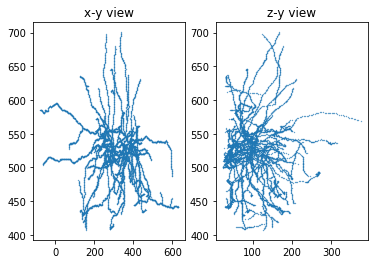

In [9]:
import neuron_morphology.swc_io as swcio
from neuron_morphology.morphology import Morphology
from neuron_morphology.swc_io import morphology_from_swc
from neuron_morphology.feature_extractor.data import Data
from neuron_morphology.feature_extractor.feature_extractor import FeatureExtractor
from neuron_morphology.features.default_features import default_features
from neuron_morphology.constants import (
    SOMA, AXON, BASAL_DENDRITE, APICAL_DENDRITE
)

def prepare_neuron_tree(swc_data):
    nodes = swc_data.to_dict('record')

    replace_type = 2 # default node type
    for node in nodes:
        node['parent'] = int(node['parent'])
        node['id'] = int(node['id'])
        node['type'] = int(node['type'])

        if node['parent'] == -1 and node['type'] != 1:
            replace_type = node['type']

        if node['type'] == 1 and node['parent'] != -1:
            node['type'] = replace_type

    soma_list = []
    for node in nodes:
        if node['type'] == 1:
            soma_list.append(node)

    # create a new soma point
    if len(soma_list) > 1:
        x = 0
        y = 0
        z = 0
        n = len(soma_list)
        for node in soma_list:
            x += node['x']
            y += node['y']
            z += node['z']

        soma = copy.deepcopy(soma_list[0])
        soma['id'] = nodes[-1]['id']
        soma['x'] = x/n
        soma['y'] = y/n
        soma['z'] = z/n
        nodes.append(soma)

        for node in soma_list:
            node['parent'] = soma['id']
            node['type'] = replace_type
    
    return nodes

# load
filepath = "/Users/youngseo/Downloads/H16-06-007-01-05-03_571972079_m.CNG.swc"
swc_data = swcio.read_swc("/Users/youngseo/Documents/UofT/Y4/Thesis/gouwens-data/data/688115867_transformed.swc")

nodes = prepare_neuron_tree(swc_data)
test_data = Data(Morphology(nodes, node_id_cb=lambda node: node['id'], parent_id_cb=lambda node: node['parent']))

# visualize
x = [node['x'] for node in nodes]
y = [node['y'] for node in nodes]
z = [node['z'] for node in nodes]

fig, ax = plt.subplots(1, 2)
ax[0].scatter(x, y, s=0.1)
ax[0].set_title('x-y view')
ax[1].scatter(z, y, s=0.1)
ax[1].set_title('z-y view')

In [8]:
# Feature Extractor (runs into error)

# fe = FeatureExtractor()
# fe.register_features(default_features)
# feature_extraction_run = fe.extract(test_data)
# results = feature_extraction_run.results
# from neuron_morphology.feature_extractor.utilities import unnest
# unnest(results)

### Plotting method used in the Gouwens paper

In [6]:
def plot_morphology(file):
    morph = morphology_from_swc(file)
    
    axon_nodes = morph.get_node_by_types([AXON])
    dend_nodes = morph.get_node_by_types([BASAL_DENDRITE])
    soma_nodes = morph.get_node_by_types([SOMA])

    axon_x = [node['x'] for node in axon_nodes]
    axon_y = [node['y'] for node in axon_nodes]

    dend_x = [node['x'] for node in dend_nodes]
    dend_y = [node['y'] for node in dend_nodes]

    soma_x = [node['x'] for node in soma_nodes]
    soma_y = [node['y'] for node in soma_nodes]


    plt.figure(figsize=(10, 10))

    plt.scatter(axon_x, axon_y, s=1, edgecolor="none")
    plt.scatter(dend_x, dend_y, s=1, edgecolor="none")
    plt.scatter(soma_x, soma_y, s=20, c="black", edgecolor="none")


    plt.gca().set(xticks=[], yticks=[])
    plt.gca().set_aspect("equal")
    sns.despine(left=True, bottom=True)
#     plt.savefig(f"./images/{os.path.basename(file)[:9]}.png")
#     plt.close()

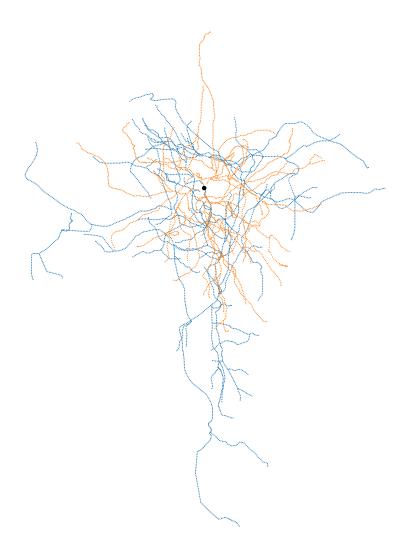

In [124]:
plot_morphology("/Users/youngseo/Documents/UofT/Y4/Thesis/gouwens-data/data/713132614_transformed.swc")

In [50]:
# Feature Extractor (result from working cell)
fe = FeatureExtractor()
fe.register_features(default_features)
feature_extraction_run = fe.extract(Data(morph))
feature_extraction_run.results

2022-09-28 15:42:52,865 root         INFO     skipping mark (validation failed): type
2022-09-28 15:42:52,866 root         INFO     skipping mark (validation failed): type
2022-09-28 15:42:52,867 root         INFO     skipping mark (validation failed): type
2022-09-28 15:42:52,871 root         INFO     selected marks: <bound method FeatureExtractionRun.select_marks of <neuron_morphology.feature_extractor.feature_extraction_run.FeatureExtractionRun object at 0x7fa7f170a250>>
2022-09-28 15:42:52,872 root         INFO     skipping feature: apical_dendrite.bifurcation.dimension. Found extra marks: ['RequiresApical']
2022-09-28 15:42:52,873 root         INFO     skipping feature: apical_dendrite.node.dimension. Found extra marks: ['RequiresApical']
2022-09-28 15:42:52,875 root         INFO     skipping feature: apical_dendrite.compartment.dimension. Found extra marks: ['RequiresApical']
2022-09-28 15:42:52,876 root         INFO     skipping feature: apical_dendrite.tip.dimension. Found extr

2022-09-28 15:42:52,923 root         INFO     skipping feature: axon.axon.earth_movers_distance. Found extra marks: ['RequiresLayeredPointDepths', 'RequiresReferenceLayerDepths']
2022-09-28 15:42:52,924 root         INFO     skipping feature: dendrite.axon.earth_movers_distance. Found extra marks: ['RequiresLayeredPointDepths', 'RequiresReferenceLayerDepths']
2022-09-28 15:42:52,925 root         INFO     selected features: ['dendrite.bifurcation.dimension', 'basal_dendrite.bifurcation.dimension', 'axon.bifurcation.dimension', 'all_neurites.bifurcation.dimension', 'dendrite.node.dimension', 'basal_dendrite.node.dimension', 'axon.node.dimension', 'all_neurites.node.dimension', 'dendrite.compartment.dimension', 'basal_dendrite.compartment.dimension', 'axon.compartment.dimension', 'all_neurites.compartment.dimension', 'dendrite.tip.dimension', 'basal_dendrite.tip.dimension', 'axon.tip.dimension', 'all_neurites.tip.dimension', 'dendrite.num_nodes', 'basal_dendrite.num_nodes', 'axon.num_node

{'dendrite.bifurcation.dimension': {'width': 108.50940818020712,
  'height': 116.98334206913108,
  'depth': 105.30393610321144,
  'min_xyz': array([-29.82098151, -98.57986847, -30.57592535]),
  'max_xyz': array([78.68842667, 18.4034736 , 74.72801075]),
  'bias_xyz': array([48.86744515, 80.17639487, 44.1520854 ])},
 'basal_dendrite.bifurcation.dimension': {'width': 108.50940818020712,
  'height': 116.98334206913108,
  'depth': 105.30393610321144,
  'min_xyz': array([-29.82098151, -98.57986847, -30.57592535]),
  'max_xyz': array([78.68842667, 18.4034736 , 74.72801075]),
  'bias_xyz': array([48.86744515, 80.17639487, 44.1520854 ])},
 'axon.bifurcation.dimension': {'width': 191.27309607099676,
  'height': 216.31038214204875,
  'depth': 118.65478773539377,
  'min_xyz': array([-122.91607096, -181.66885685,  -49.17659857]),
  'max_xyz': array([68.35702512, 34.64152529, 69.47818917]),
  'bias_xyz': array([ 54.55904584, 147.02733156,  20.3015906 ])},
 'all_neurites.bifurcation.dimension': {'wid

### Collect Morphology Features

In [11]:
def flatten_features(fd):
    fd_flat = {}
    for k, v in fd.items():
        if type(v) == dict:
            for vk, vv in v.items():
                subkey = k + "_" + vk
                if type(vv) == np.ndarray:
                    fd_flat[subkey + "_x"] = vv[0]
                    fd_flat[subkey + "_y"] = vv[1]
                    fd_flat[subkey + "_z"] = vv[2]
                else:
                    fd_flat[subkey] = vv
        else:
            fd_flat[k] = v
    return fd_flat

In [12]:
def extract_features(file):
    morph = morphology_from_swc(file)
    
    fe = FeatureExtractor()
    fe.register_features(default_features)

    feature_extraction_run = fe.extract(Data(morph))
    return flatten_features(dict(feature_extraction_run.results))

In [13]:
def process_features(file):
    name = os.path.basename(file)[:9]
    print(f"Collecting features from Cell {name}.\n")
    try:
        features = extract_features(file)
        return name, features
    except:
        return name, None

In [14]:
def collect_morph_features(files, chunksize):
    feature_dict = {}
    fail_count = 0
    fail_cells = []
    with Pool() as p:
        for name, features in p.imap_unordered(process_features, files, chunksize=chunksize):
            if features:
                feature_dict[name] = features
            else:
                fail_count += 1
                fail_cells.append(name)
    df = pd.DataFrame.from_dict(feature_dict, orient="index")
    df.to_csv("./morphology_features_science_staging.csv")
    print(f"Collected morphology features from {len(files) - fail_count} cells.")
    print(f"Failed cells: {fail_cells}")

In [17]:
features = extract_features("/Users/youngseo/Documents/UofT/Y4/Thesis/gouwens-data/data/713132614_transformed.swc")
features

In [9]:
# Extracting features from all morphologies (long runtime, fails on many cells)

# from time import time
# t = time()
# collect_morph_features(swc_files, "./morphology_features_v3.csv")
# print(f"Runtime: {time() - t}s")

In [58]:
data = pd.read_csv("./morphology_features.csv", index_col=0)
data

,all_neurites.compartment.dimension_width,all_neurites.compartment.dimension_height,all_neurites.compartment.dimension_depth,all_neurites.compartment.dimension_min_xyz_x,all_neurites.compartment.dimension_min_xyz_y,all_neurites.compartment.dimension_min_xyz_z,all_neurites.compartment.dimension_max_xyz_x,all_neurites.compartment.dimension_max_xyz_y,all_neurites.compartment.dimension_max_xyz_z,all_neurites.compartment.dimension_bias_xyz_x,...,apical_dendrite.node.moments_std_z,apical_dendrite.node.moments_var_x,apical_dendrite.node.moments_var_y,apical_dendrite.node.moments_var_z,apical_dendrite.node.moments_skew_x,apical_dendrite.node.moments_skew_y,apical_dendrite.node.moments_skew_z,apical_dendrite.node.moments_kurt_x,apical_dendrite.node.moments_kurt_y,apical_dendrite.node.moments_kurt_z
795563325,508.698073,550.052275,318.189657,-217.769696,-335.663630,-43.460889,290.928377,214.388645,274.728768,73.158681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755625739,418.285041,636.918408,328.492359,-243.570124,-285.798900,-55.938733,174.714918,351.119508,272.553627,68.855206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
663193112,655.651447,342.559506,412.862878,-256.961563,-185.419665,-49.753074,398.689884,157.139840,363.109804,141.728321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
899368360,451.888716,859.296911,333.481432,-148.937987,-573.242955,-66.439643,302.950729,286.053956,267.041789,154.012741,...,49.1226,1983.2867,9717.473884,2413.029836,0.098229,-0.250646,0.796168,0.193878,-1.476706,-0.05455
718237581,473.366146,479.313839,393.691046,-205.539597,-205.940349,-62.908117,267.826549,273.373491,330.782929,62.286951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888108541,377.430881,387.710279,389.525130,-192.645360,-193.009039,-70.035479,184.785521,194.701240,319.489651,7.859838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
646852171,317.871284,377.059447,257.984834,-144.591276,-187.926765,-77.948989,173.280009,189.132682,180.035845,28.688733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
682454193,386.594420,591.050773,370.224767,-159.435451,-411.203840,-60.365850,227.158968,179.846933,309.858917,67.723517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729135271,453.731729,820.016114,407.109489,-178.420490,-308.563692,-65.793328,275.311240,511.452423,341.316161,96.890750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Collect 2D Images

In [16]:
def collect_morph_images(files):
    fail_count = 0
    processed = 0
    for file in files:
        processed += 1
        if processed % 50 == 0:
            print(f"Processed {processed} images.")
        try:
            plot_morphology(file)
        except:
            fail_count += 1
    print(f"Collected 2D morphology images from {len(files) - fail_count} cells.")

In [10]:
# Collecting images from all SWC files

# collect_morph_images(swc_files)

### Analyze extracted morphology features

In [13]:
# Gather t-type information per cell
metadata = pd.read_csv("./20200711_patchseq_metadata_mouse.csv")
labels = metadata[["cell_specimen_id", metadata.columns[-1]]]
labels.columns = ["cell_id", "t-type"]
labels

,cell_id,t-type
0,601506507,Vip Gpc3 Slc18a3
1,601790961,Sst Tac2 Myh4
2,601803754,Sst Calb2 Pdlim5
3,601808698,Sst Hpse Cbln4
4,601810307,Sst Calb2 Necab1
...,...,...
4430,1003020818,Lamp5 Lsp1
4431,1003305641,Pvalb Vipr2
4432,1003313398,Pvalb Vipr2
4433,1003321825,Pvalb Vipr2


In [14]:
# Get t-type labels for cells with features
features = pd.read_csv("./morphology_features.csv", index_col=0)
cell_ids = [i for i, _ in features.iterrows()]
cell_labels = labels[labels["cell_id"].isin(cell_ids)]
cell_labels

,cell_id,t-type
3,601808698,Sst Hpse Cbln4
6,602231708,Sst Calb2 Pdlim5
9,604646725,Vip Pygm C1ql1
10,605060256,Vip Lmo1 Myl1
13,606271263,Pvalb Vipr2
...,...,...
4351,962355052,NaN
4352,962821095,NaN
4354,963019667,NaN
4355,963055521,NaN


In [15]:
len(labels[labels['t-type'].isna()])

165

In [16]:
# Get cells with t-type information
cell_labels = cell_labels[~cell_labels['t-type'].isna()]
cell_labels

,cell_id,t-type
3,601808698,Sst Hpse Cbln4
6,602231708,Sst Calb2 Pdlim5
9,604646725,Vip Pygm C1ql1
10,605060256,Vip Lmo1 Myl1
13,606271263,Pvalb Vipr2
...,...,...
4046,873854264,Sst Chodl
4073,887048277,Pvalb Akr1c18 Ntf3
4083,888108541,Lamp5 Ntn1 Npy2r
4092,889235347,Lamp5 Plch2 Dock5


In [17]:
# Get t-types with 5 or more cells that have morphology features
cell_type_counts = cell_labels['t-type'].value_counts()
# sig_cell_types = list(cell_type_counts[cell_type_counts >= 5].to_dict().keys())
sig_cell_types = cell_type_counts[cell_type_counts >= 5].to_dict()
sig_cell_types

{'Pvalb Reln Itm2a': 13,
 'Sst Chodl': 13,
 'Lamp5 Lsp1': 11,
 'Sst Calb2 Pdlim5': 11,
 'Sst Hpse Cbln4': 11,
 'Sst Crhr2 Efemp1': 11,
 'Pvalb Tpbg': 9,
 'Lamp5 Plch2 Dock5': 9,
 'Sst Mme Fam114a1': 9,
 'Pvalb Sema3e Kank4': 7,
 'Sst Tac1 Htr1d': 6,
 'Pvalb Akr1c18 Ntf3': 6,
 'Sst Crh 4930553C11Rik ': 6,
 'Sst Rxfp1 Eya1': 5,
 'Lamp5 Ntn1 Npy2r': 5,
 'Sncg Vip Itih5': 5,
 'Sncg Vip Nptx2': 5}

In [62]:
# Get list of cell IDs for significant t-types
sig_cells = cell_labels[cell_labels["t-type"].isin(sig_cell_types)]
sig_cell_ids = list(sig_cells["cell_id"])
len(sig_cell_ids)

142

In [69]:
# Get final input matrix for Random Forest Classifier
input_data = pd.read_csv("./morphology_features.csv", index_col=0)
input_data = input_data[input_data.index.isin(sig_cell_ids)]
input_data = input_data.dropna(axis=1)

# Merge features with labels
input_data = pd.merge(input_data, cell_labels, left_index=True, right_on="cell_id")
input_data = input_data.set_index("cell_id")
input_data.to_csv("./filtered_input_with_labels.csv")
input_data

,all_neurites.compartment.dimension_width,all_neurites.compartment.dimension_height,all_neurites.compartment.dimension_depth,all_neurites.compartment.dimension_min_xyz_x,all_neurites.compartment.dimension_min_xyz_y,all_neurites.compartment.dimension_min_xyz_z,all_neurites.compartment.dimension_max_xyz_x,all_neurites.compartment.dimension_max_xyz_y,all_neurites.compartment.dimension_max_xyz_z,all_neurites.compartment.dimension_bias_xyz_x,...,axon.node.moments_var_x,axon.node.moments_var_y,axon.node.moments_var_z,axon.node.moments_skew_x,axon.node.moments_skew_y,axon.node.moments_skew_z,axon.node.moments_kurt_x,axon.node.moments_kurt_y,axon.node.moments_kurt_z,t-type
cell_id,,,,,,,,,,,,,,,,,,,,,
718237581,473.366146,479.313839,393.691046,-205.539597,-205.940349,-62.908117,267.826549,273.373491,330.782929,62.286951,...,5578.148886,3100.572424,6672.029524,0.082979,-0.148742,0.523156,0.403464,-0.629201,-0.485932,Pvalb Sema3e Kank4
637846989,267.036348,366.892832,238.400926,-133.135063,-250.985894,-56.940200,133.901285,115.906938,181.460726,0.766222,...,2095.392387,4105.681229,1029.309441,-0.318033,-1.110428,0.424059,0.956770,0.911897,-0.473141,Lamp5 Lsp1
740875222,383.936679,479.410651,366.776200,-174.944880,-198.978016,-70.662142,208.991799,280.432635,296.114059,34.046919,...,3688.368907,6437.819274,3466.787071,-0.576248,0.193146,0.284553,0.477186,0.679121,-0.459722,Sst Chodl
657454163,212.234744,481.947535,224.989815,-107.114321,-165.302421,-30.817025,105.120423,316.645114,194.172790,1.993897,...,1102.674105,3197.481686,1631.913050,-0.040848,0.356528,0.712316,-0.315424,2.208519,-0.090330,Sst Hpse Cbln4
718205473,469.837578,306.963027,375.874083,-193.354450,-157.752998,-46.210661,276.483128,149.210028,329.663422,83.128678,...,7830.460740,1787.075797,3196.252713,0.133739,0.419493,0.746968,0.203224,-0.049571,-0.046161,Sst Crhr2 Efemp1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674069192,971.255310,583.091973,397.881075,-414.568575,-440.401275,-96.812352,556.686735,142.690697,301.068723,142.118160,...,17218.295762,7647.367012,5979.150124,0.356911,-2.627412,0.425709,2.519630,8.451987,-0.400019,Sst Calb2 Pdlim5
888108541,377.430881,387.710279,389.525130,-192.645360,-193.009039,-70.035479,184.785521,194.701240,319.489651,7.859838,...,3553.605355,6904.879816,6181.952307,0.255941,0.330159,0.957647,0.282497,-0.868758,0.495218,Lamp5 Ntn1 Npy2r
646852171,317.871284,377.059447,257.984834,-144.591276,-187.926765,-77.948989,173.280009,189.132682,180.035845,28.688733,...,2854.974557,3576.426587,2524.722988,0.242827,-0.968905,0.416663,0.149389,1.776476,-0.478723,Pvalb Reln Itm2a


### Run Random Forest Classifier on extracted features and labels

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [14]:
input_matrix = pd.read_csv("./gouwens-data/filtered_input_with_labels.csv", index_col=0)
y = input_matrix["t-type"]
X = input_matrix.drop("t-type", axis=1)

X_train, X_test = X[:110], X[110:]
y_train, y_test = y[:110], y[110:]

rfc = RandomForestClassifier(n_estimators=500, oob_score=True)
rfc.fit(X_train, y_train)

rfc.score(X_test, y_test)

0.34375

Accuracy for fold 1: 0.3793103448275862
Accuracy for fold 2: 0.3793103448275862
Accuracy for fold 3: 0.35714285714285715
Accuracy for fold 4: 0.32142857142857145
Accuracy for fold 5: 0.39285714285714285


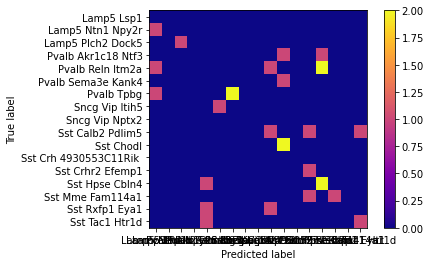

Average accuracy: 0.36600985221674875


In [19]:
# 5-fold Cross Validation
input_matrix = pd.read_csv("./gouwens-data/filtered_input_with_labels.csv", index_col=0)
y = input_matrix["t-type"]
X = input_matrix.drop("t-type", axis=1)

X = X.reset_index(drop=True).to_numpy()
y = y.reset_index(drop=True).to_numpy()

k = 0
acc_sum = 0
for train_index, test_index in KFold(n_splits=5).split(X):
    k += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rfc = RandomForestClassifier(n_estimators=500, oob_score=True)
    rfc.fit(X_train, y_train)
    acc = rfc.score(X_test, y_test)
    print(f"Accuracy for fold {k}: {acc}")
    acc_sum += acc
    
    if (k == 5):
        pred = rfc.predict(X_test)
        cm = confusion_matrix(y_test, pred, labels=rfc.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
        disp.plot(include_values=False, cmap='plasma')
        plt.show()
print(f"Average accuracy: {acc_sum / k}")

In [113]:
# Try with all 204 cells
input_data = pd.read_csv("./morphology_features.csv", index_col=0)
input_data = input_data[input_data.index.isin(list(cell_labels['cell_id']))]
input_data = input_data.dropna(axis=1)

# Merge features with labels
input_data = pd.merge(input_data, cell_labels, left_index=True, right_on="cell_id")
input_data = input_data.set_index("cell_id")

# 5-fold Cross Validation
y = input_data["t-type"]
X = input_data.drop("t-type", axis=1)

X = X.reset_index(drop=True).to_numpy()
y = y.reset_index(drop=True).to_numpy()

k = 0
acc_sum = 0
for train_index, test_index in KFold(n_splits=5).split(X):
    k += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rfc = RandomForestClassifier(n_estimators=500, oob_score=True)
    rfc.fit(X_train, y_train)
    acc = rfc.score(X_test, y_test)
    print(f"Accuracy for fold {k}: {acc}")
    acc_sum += acc
print(f"Average accuracy: {acc_sum / k}")

Accuracy for fold 1: 0.21951219512195122
Accuracy for fold 2: 0.24390243902439024
Accuracy for fold 3: 0.2682926829268293
Accuracy for fold 4: 0.21951219512195122
Accuracy for fold 5: 0.25
Average accuracy: 0.24024390243902438


In [117]:
# Try with transcriptomic subclasses
input_data = pd.read_csv("./morphology_features.csv", index_col=0)
input_data = input_data[input_data.index.isin(list(cell_labels['cell_id']))]
input_data = input_data.dropna(axis=1)

# Merge features with labels
input_data = pd.merge(input_data, cell_labels, left_index=True, right_on="cell_id")
input_data = input_data.set_index("cell_id")

# 5-fold Cross Validation
y = input_data["t-type"]
X = input_data.drop("t-type", axis=1)

X = X.reset_index(drop=True).to_numpy()
y = y.reset_index(drop=True).to_numpy()

# Extract t-subclasses
y = np.array([t[:3] for t in list(y)]).reshape(-1,)

k = 0
acc_sum = 0
for train_index, test_index in KFold(n_splits=5).split(X):
    k += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rfc = RandomForestClassifier(n_estimators=500, oob_score=True)
    rfc.fit(X_train, y_train)
    acc = rfc.score(X_test, y_test)
    print(f"Accuracy for fold {k}: {acc}")
    acc_sum += acc
print(f"Average accuracy: {acc_sum / k}")

204
Accuracy for fold 1: 0.6585365853658537
Accuracy for fold 2: 0.7317073170731707
Accuracy for fold 3: 0.7560975609756098
Accuracy for fold 4: 0.6097560975609756
Accuracy for fold 5: 0.65
Average accuracy: 0.681219512195122


In [129]:
input_matrix = pd.read_csv("./filtered_input_with_labels.csv", index_col=0)
cells_with_labels = list(input_matrix.index)
len(cells_with_labels)

142

In [130]:
for cnt, cell in enumerate(cells_with_labels):
    src = f"./images/{cell}.png"
    dst = f"./images_with_labels/{cell}.png"
    shutil.copy(src, dst)
    if (cnt > 0 and cnt % 100 == 0):
        print(f"Copied {cnt} files.")

Copied 100 files.


### Collect training data for CNN

In [19]:
# Get t-type labels for cells with features
image_ids = [os.path.splitext(os.path.basename(i))[0] for i in glob.glob("./images/*.png")]
cell_labels = labels[labels["cell_id"].isin(image_ids)]
cell_labels = cell_labels[~cell_labels['t-type'].isna()]
cell_labels

,cell_id,t-type
0,601506507,Vip Gpc3 Slc18a3
1,601790961,Sst Tac2 Myh4
2,601803754,Sst Calb2 Pdlim5
3,601808698,Sst Hpse Cbln4
4,601810307,Sst Calb2 Necab1
...,...,...
4092,889235347,Lamp5 Plch2 Dock5
4155,898697809,Vip Lmo1 Myl1
4156,898703349,Vip Lmo1 Myl1
4180,904023586,Pvalb Akr1c18 Ntf3


In [20]:
# Get t-types with 5 or more cells that have morphology features
cell_type_counts = cell_labels['t-type'].value_counts()
# sig_cell_types = list(cell_type_counts[cell_type_counts >= 5].to_dict().keys())
significant_cells = cell_type_counts[cell_type_counts >= 5].to_dict()
significant_cells

{'Sst Hpse Cbln4': 28,
 'Sst Calb2 Pdlim5': 27,
 'Pvalb Reln Itm2a': 22,
 'Sst Crhr2 Efemp1': 19,
 'Lamp5 Plch2 Dock5': 18,
 'Sst Esm1': 17,
 'Sst Chodl': 16,
 'Sst Tac1 Htr1d': 15,
 'Lamp5 Lsp1': 15,
 'Pvalb Tpbg': 15,
 'Sst Mme Fam114a1': 14,
 'Pvalb Sema3e Kank4': 13,
 'Vip Lmo1 Myl1': 13,
 'Sst Myh8 Etv1 ': 13,
 'Sst Tac2 Tacstd2': 12,
 'Vip Pygm C1ql1': 11,
 'Sst Rxfp1 Prdm8': 10,
 'Sst Nts': 10,
 'Sst Hpse Sema3c': 10,
 'Vip Crispld2 Kcne4': 10,
 'Sst Rxfp1 Eya1': 10,
 'Vip Ptprt Pkp2': 9,
 'Sncg Vip Itih5': 9,
 'Lamp5 Ntn1 Npy2r': 9,
 'Sst Calb2 Necab1': 9,
 'Sst Crh 4930553C11Rik ': 8,
 'Vip Crispld2 Htr2c': 8,
 'Sst Nr2f2 Necab1': 8,
 'Pvalb Akr1c18 Ntf3': 8,
 'Vip Chat Htr1f': 7,
 'Sst Chrna2 Glra3': 7,
 'Sst Tac1 Tacr3': 6,
 'Sncg Vip Nptx2': 6,
 'Vip Lect1 Oxtr': 6,
 'Sncg Gpr50': 6,
 'Pvalb Reln Tac1': 5,
 'Pvalb Gabrg1': 5,
 'Pvalb Calb1 Sst': 5,
 'Pvalb Th Sst': 5}

In [24]:
# Get list of cell IDs for significant t-types
sig_cells = cell_labels[cell_labels["t-type"].isin(sig_cell_types)]
sig_cell_ids = list(sig_cells["cell_id"])
len(sig_cell_ids)

252

In [25]:
# Use 17 most prominent cell types from feature extraction
for cnt, cell in enumerate(sig_cell_ids):
    src = f"./images/{cell}.png"
    dst = f"./images_with_labels/{cell}.png"
    shutil.copy(src, dst)
    if (cnt > 0 and cnt % 20 == 0):
        print(f"Copied {cnt} files.")

Copied 20 files.
Copied 40 files.
Copied 60 files.
Copied 80 files.
Copied 100 files.
Copied 120 files.
Copied 140 files.
Copied 160 files.
Copied 180 files.
Copied 200 files.
Copied 220 files.
Copied 240 files.


In [26]:
sig_cells.to_csv("input_image_ids_with_labels.csv")

## Scala Data

In [6]:
scala_files = glob.glob("/Users/youngseo/Documents/UofT/Y4/Thesis/scala-data/inhibitory/raw/*.SWC")
len(scala_files)

371

In [10]:
scala_files[0]

'/Users/youngseo/Documents/UofT/Y4/Thesis/scala-data/inhibitory/raw/20190408_sample_6.SWC'

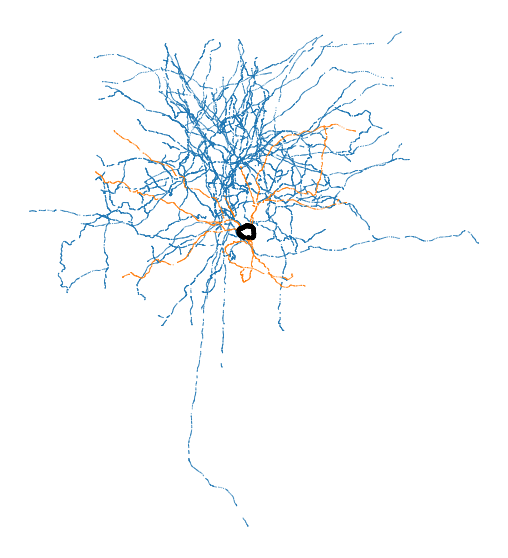

In [9]:
plot_morphology(scala_files[0])